# Objective: Understand how to overlay pyplot hist objects

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

In [2]:
#Peak VCD per D42 bioreactor for experiment and control 
exp = [42.62, 54.55, 62.75, 62.4, 53.29, 60.7, 21.37, 35.56, 18.51, 36.54, 43.38, 15.91, 25.12, 22.2, 34.68,
       47.89, 41.09, 43.8, 27.3, 35.38, 72.46, 33.51, 22.96, 48.92, 64.26, 18.83, 8.59, 24.63, 28.36, 29.63, 
       28.47, 43.18, 30.89, 24.19, 21.52, 31.11, 40.76, 31.94, 34.82, 7.45, 19.9]
control = [29.97, 30.32, 48.28, 30.95, 27.34, 31.37, 35.77, 29.25]

#### Converting lists of data to DF attempt 1

Problem: Cannot convert lists of different lengths into a dataframe 

In [3]:
#long solution: convert to dict of series manually then to dataframe 
exp_series = pd.Series(exp)
control_series = pd.Series(control)

series_dict = {"a":exp_series,
              "b":control_series}

#Dataframe came make dataframes from Series dtypes that are not the same length but not from lists 
df_data = pd.DataFrame(series_dict)

In [4]:
#more concise way, use dict comprehension to convert dict of lists to dict of series then to dataframe 

data_dict = {"exp": exp,
            "control": control}

series_dict_1 = {k: pd.Series(v) for k,v in data_dict.items()}
df_data_1 = pd.DataFrame(series_dict_1)


#### Converting lists of data to DF attempt 2

Problem: joined dataframe may work for historgrams in this case, but want to be able to have 1 data column and descriptive column, then group and plot

In [5]:
# long solution: manually create extra column with type of data then concat, reset index and drop old index 

In [6]:
#manual series to dataframe and manual add of type column
df_test_exp = pd.DataFrame(exp_series, columns = ["vcd"])
df_test_exp["type"] = "exp"

df_test_control = pd.DataFrame(control_series, columns = ["vcd"])
df_test_control["type"] = "control"

df_merged = pd.concat([df_test_control, df_test_exp]) #glue together on axis = 0

df_merged.reset_index(inplace = True, drop = True) #reset index and drop old index and done!

## OK now need to plot the histograms

type
control    AxesSubplot(0.125,0.125;0.775x0.755)
exp        AxesSubplot(0.125,0.125;0.775x0.755)
Name: vcd, dtype: object

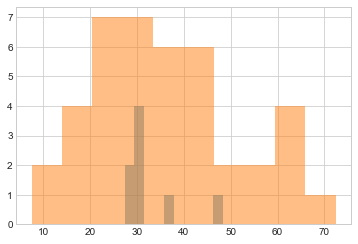

In [7]:
# Using pandas and groupby, quick way for a single grouped histogram 

#I dont know how to control the color of each group

df_merged.groupby("type")["vcd"].hist(alpha = 0.5,)

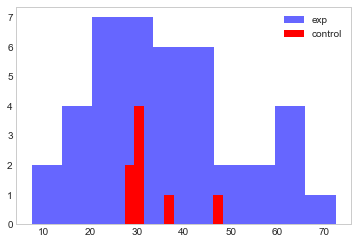

In [8]:
#Using matplotlib to overlay plots with color transperancy 
# I can easily control the color of each subplot 

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.hist(df_merged[df_merged["type"] == "exp"]["vcd"], label = "exp", alpha = 0.6, color = "b")
ax.hist(df_merged[df_merged["type"] == "control"]["vcd"], label ="control", color = "red")

plt.legend()

## To learn 

How to generally interacts with the pandas plots 
- is it worth even using pandas instead of creating it with matplotlib?

How to set plot styles to be seaborn like but without background or grid 

How to create grouped overlayed histograms for every feature


links:
https://stackoverflow.com/questions/23617129/matplotlib-how-to-make-two-histograms-have-the-same-bin-width
^ whats up with n bins batches?
https://stackoverflow.com/questions/35878064/plot-two-histograms-on-the-same-graph-and-have-their-columns-sum-to-100
^generic histogram plot

# Creating grouped historgrams with larger dataset (D42 Data)

In [9]:
df = pd.read_csv("D42-CHR-0060 DOE JMP 100418 Day14Subset.csv") #import the csv dataset file
df_outputes = df.iloc[:,8:20] #isolate only the columns with dependant variables (experimental outputs)
df_outputes = pd.concat([df_outputes, df["Cond"]], axis = 1) #add a categorical column from original data to outputs

### Objective: Create a function that plots histograms for every column in a dataframe that is grouped by

In [211]:
def grouped_histograms(df_data, df_group):
    
    """
    arguments: 
    df_data = dataframe containing columns of data to be plotted as a histogram.  
    df_group = dataframe containing a single column of categorical data. 
                must be same number of rows as df_data. 
                
    return: no object returned, however hist.png is saved in local dir
    """
    
    #forcing to use the following colors in this order for hist
    colors_list = ["blue","crimson", "green", "cyan", "violet", "orange", "lime", "gold"]
    
    groups = df_group["Cond"].unique() #array of unique groups
    n = 0 #counting subplots 
    
    
    #logic for # of subplot rows for (# rows) x 4 subplot grid 
    if len(df_data.columns)%4 > 0:
        plt_rows = (int(len(df_data.columns)) + 1)
    else:
        plt_rows = int(len(df_data.columns)/4)

    
    fig = plt.figure(figsize = (30,20)) 
    
    #for every column, create a subplot. 
    for i in df_data.columns:
        
        bin_count = int((len(df[i]))**(1/2)) # (# of bins) = sqaure root of number of data points, i.e., column length
        bin_edges = np.histogram(df_data[i].dropna(), bins = bin_count)[1] #getting bin edges for all the data (all groups)
        
        n +=1
        ax = fig.add_subplot(plt_rows,4,n)
        ax.set_title(i, fontsize = 20, fontweight = "bold")
        ax.tick_params(axis='both', which='major', labelsize=16)
        
        # for every group, draw a hist 
        for p, color in zip(groups, colors_list):
             #index by group,
            ax.hist(df_data[df_group.iloc[:,0] == p][i].dropna(), bins = bin_edges,  alpha = 0.7, label = p, color = color)
        plt.legend(fontsize = 16)

    plt.tight_layout
    plt.savefig("hist.png", bbox_inches = "tight", dpi = 200)
    return

In [212]:
df_0 = df_outputes.iloc[:,:-1]
df_1 = pd.DataFrame(df_outputes.iloc[:,-1])

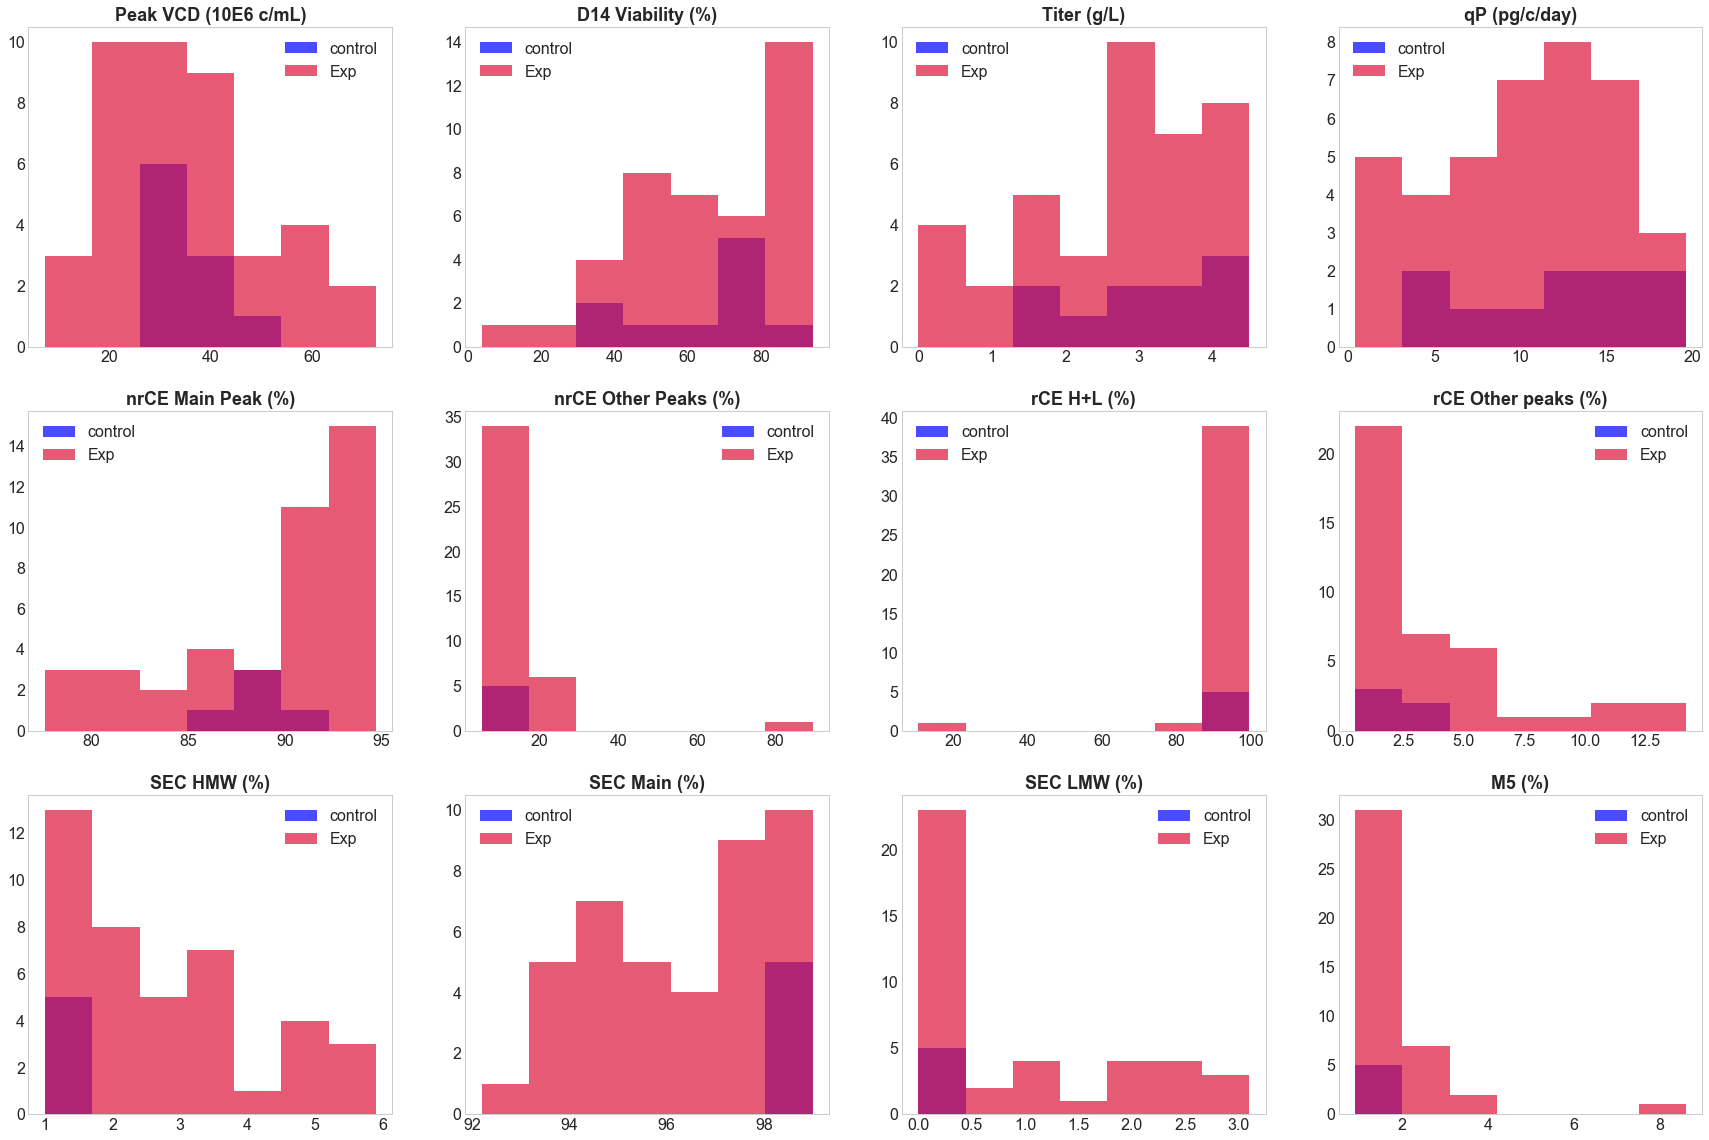

In [213]:
grouped_histograms(df_0, df_1)

# How does this work? the n, bins, patches part?
https://stackoverflow.com/questions/23617129/matplotlib-how-to-make-two-histograms-have-the-same-bin-width
recurring with colors for hist:
https://stackoverflow.com/questions/43872450/matplotlib-histogram-with-legend


links: https://stackoverflow.com/questions/23617129/matplotlib-how-to-make-two-histograms-have-the-same-bin-width ^ whats up with n bins batches? https://stackoverflow.com/questions/35878064/plot-two-histograms-on-the-same-graph-and-have-their-columns-sum-to-100 ^generic histogram plot

# Appendix

In [199]:
for i in df_0.columns:
    bins = int((len(df[i]))**(1/2))
    print (bins)

7
7
7
7
7
7
7
7
7
7
7
7


In [113]:
np?

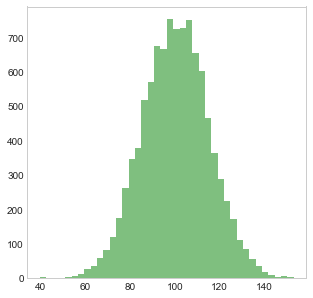

In [176]:
mu = 100 # mean of distribution
sigma = 15 # standard deviation of distribution
x = mu + sigma * np.random.randn(10000)
num_bins = 40

fig = plt.figure(figsize=(5,5))

n, bins, patches = plt.hist(x, num_bins, facecolor='green', alpha=0.5)


In [42]:
x

array([ 82.62832959, 107.17879269, 115.48211188, ..., 107.66352978,
       138.64346195, 110.42939651])

In [40]:
print(x)

[ 82.62832959 107.17879269 115.48211188 ... 107.66352978 138.64346195
 110.42939651]


In [177]:
bins

array([ 39.64432803,  42.47926126,  45.31419449,  48.14912772,
        50.98406095,  53.81899419,  56.65392742,  59.48886065,
        62.32379388,  65.15872711,  67.99366034,  70.82859357,
        73.66352681,  76.49846004,  79.33339327,  82.1683265 ,
        85.00325973,  87.83819296,  90.67312619,  93.50805943,
        96.34299266,  99.17792589, 102.01285912, 104.84779235,
       107.68272558, 110.51765882, 113.35259205, 116.18752528,
       119.02245851, 121.85739174, 124.69232497, 127.5272582 ,
       130.36219144, 133.19712467, 136.0320579 , 138.86699113,
       141.70192436, 144.53685759, 147.37179083, 150.20672406,
       153.04165729])

### Several ways of creating a random distribution

In [79]:
mu = 10
sigma = 15
distribution = mu + sigma * np.random.randn(100)

In [104]:
dist = np.random.normal(loc = 0, scale = 15, size = 100) #loc = mean, scale = std dev, size = number of values 

In [106]:
bins = np.histogram(df_0[0]

In [207]:
np.histogram(df_0[df_0.columns[0]], bins = 30)

(array([2, 0, 0, 1, 0, 3, 3, 3, 1, 4, 7, 2, 6, 3, 0, 2, 4, 0, 2, 1, 0, 2,
        0, 0, 1, 2, 1, 0, 0, 1], dtype=int64),
 array([ 7.45 ,  9.617, 11.784, 13.951, 16.118, 18.285, 20.452, 22.619,
        24.786, 26.953, 29.12 , 31.287, 33.454, 35.621, 37.788, 39.955,
        42.122, 44.289, 46.456, 48.623, 50.79 , 52.957, 55.124, 57.291,
        59.458, 61.625, 63.792, 65.959, 68.126, 70.293, 72.46 ]))

In [110]:
a=np.random.random(100)*0.5 #a uniform distribution
b=1-np.random.normal(size=100)*0.1 #a normal distribution 
bins=np.histogram(np.hstack((a,b)), bins=40)[1] #get the bin edges

In [111]:
np.histogram?

In [117]:
a = np.random.normal(loc = 0, scale = 5, size = 100)
b = np.random.normal(loc = 4, scale = 0.5, size =100)

In [150]:
b

array([4.16060458, 4.62567337, 3.54963478, 3.5818498 , 4.39940565,
       3.20182931, 4.16687287, 3.92763928, 3.98943648, 4.50813151,
       2.71921688, 4.77049658, 4.56582485, 4.07286658, 4.21578802,
       4.01818663, 3.59483351, 3.86117303, 3.96270373, 3.53672919,
       4.6154836 , 4.46022265, 3.54537147, 3.10469785, 3.57358793,
       3.8912687 , 4.4326726 , 4.4275813 , 3.24413622, 4.73666785,
       3.59797569, 3.45071128, 3.3980964 , 3.56505822, 4.94081793,
       4.35846529, 4.67419859, 3.636349  , 4.48866057, 4.63425212,
       4.20407271, 4.41128497, 3.67094881, 4.7587911 , 4.98051383,
       4.1956193 , 3.81669968, 3.78640133, 3.56432802, 3.98181565,
       4.90213002, 3.96046456, 3.97741769, 4.00570398, 4.07978293,
       3.86008889, 2.74948212, 3.89490972, 4.25744832, 3.83747752,
       2.77395561, 3.41552081, 3.4014241 , 4.06129747, 3.16976004,
       3.941427  , 3.87765136, 4.3581999 , 4.39273667, 3.97782058,
       4.57388622, 4.13131471, 3.26043958, 3.84128726, 4.40299

TypeError: unsupported operand type(s) for ^: 'int' and 'float'

In [192]:
exp = int(len(c)**(1/2))


In [193]:
exp

14

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  6., 90.,  4.,  0.,  0.,
         0.]), array([-11.98822231, -10.30666257,  -8.62510284,  -6.94354311,
         -5.26198338,  -3.58042365,  -1.89886392,  -0.21730419,
          1.46425554,   3.14581527,   4.82737501,   6.50893474,
          8.19049447,   9.8720542 ,  11.55361393]), <a list of 14 Patch objects>)

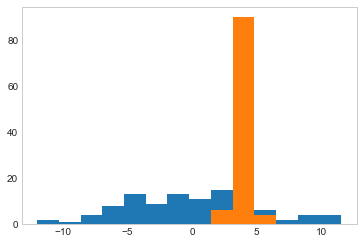

In [194]:
c = np.concatenate([a,b])
bins = np.histogram(c, bins = exp)[1]

plt.hist(a, bins)
plt.hist(b, bins)


In [155]:
np.shape(np.hstack([a,b]))

(200,)

In [169]:
np.histogram(c, bins = 40)[1]

array([-11.98822231, -11.3996764 , -10.81113049, -10.22258459,
        -9.63403868,  -9.04549278,  -8.45694687,  -7.86840096,
        -7.27985506,  -6.69130915,  -6.10276325,  -5.51421734,
        -4.92567143,  -4.33712553,  -3.74857962,  -3.16003372,
        -2.57148781,  -1.98294191,  -1.394396  ,  -0.80585009,
        -0.21730419,   0.37124172,   0.95978762,   1.54833353,
         2.13687944,   2.72542534,   3.31397125,   3.90251715,
         4.49106306,   5.07960897,   5.66815487,   6.25670078,
         6.84524668,   7.43379259,   8.0223385 ,   8.6108844 ,
         9.19943031,   9.78797621,  10.37652212,  10.96506803,
        11.55361393])

In [172]:
np.histogram(c)[1]

array([-11.98822231,  -9.63403868,  -7.27985506,  -4.92567143,
        -2.57148781,  -0.21730419,   2.13687944,   4.49106306,
         6.84524668,   9.19943031,  11.55361393])

In [170]:
np.histogram?

In [118]:
np.hstack?

In [ ]:
a = np.random.normal

In [131]:
a_0 = np.ndarray(shape = (2,10))
b_0 = np.ndarray(shape = (3,4))

In [133]:
dfb_0 = pd.DataFrame(b_0)

In [129]:
dfa_0 = pd.DataFrame(a_0)

In [130]:
dfa_0

,0,1,2,3,4,5,6,7,8,9
0,0.1,0.15,0.2,0.25,0.3,0.4,0.5,0.6,0.8,1.0
1,1.5,2.00,2.5,3.00,4.0,5.0,6.0,8.0,10.0,15.0


In [134]:
dfb_0

,0,1,2,3
0,6.952494e-310,6.952494e-310,6.952494e-310,6.952494e-310
1,6.952494e-310,6.952494e-310,6.952494e-310,6.952494e-310
2,6.952494e-310,6.952494e-310,6.952494e-310,6.952494e-310


In [146]:
c = pd.concat([dfa_0, dfb_0], axis = 0, ignore_index=True)

In [147]:
c

,0,1,2,3,4,5,6,7,8,9
0,1.000000e-01,1.500000e-01,2.000000e-01,2.500000e-01,0.3,0.4,0.5,0.6,0.8,1.0
1,1.500000e+00,2.000000e+00,2.500000e+00,3.000000e+00,4.0,5.0,6.0,8.0,10.0,15.0
2,6.952494e-310,6.952494e-310,6.952494e-310,6.952494e-310,NaN,NaN,NaN,NaN,NaN,NaN
3,6.952494e-310,6.952494e-310,6.952494e-310,6.952494e-310,NaN,NaN,NaN,NaN,NaN,NaN
4,6.952494e-310,6.952494e-310,6.952494e-310,6.952494e-310,NaN,NaN,NaN,NaN,NaN,NaN


In [148]:
np.hstack?